Source - https://www.kaggle.com/code/mgmarques/customer-segmentation-and-market-basket-analysis#Customer-Segmentation:


Data set is of a UK based customer sales company

In [1]:
# install necessary dependencies


In [97]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('whitegrid')
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [4]:
# other libraries
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
cd_or_df = pd.read_excel("../data/Online Retail.xlsx")

In [6]:
cd_or_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Data Description**

- **InvoiceNo**: a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: product name.
- **Quantity**: the quantities of each product (item) per transaction.
- **InvoiceDate**: the day and time when each transaction was generated.
- **UnitPrice**: product price per unit.
- **CustomerID**: a 5-digit integral number uniquely assigned to each customer.
- **Country**: the name of the country where each customer resides.

## Exploratory Data Analysis

In [7]:
cd_or_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
cd_or_df.duplicated().sum()

5268

In [9]:
cd_or_df.dtypes.value_counts()

object            4
float64           2
int64             1
datetime64[ns]    1
Name: count, dtype: int64

There are some duplicates involved in the data, which needs to be removed further down the line.

In [10]:
# getting internal details of the data using a function

def get_structure(df):
    n_rows = df.shape[0]
    d_types = df.dtypes
    total_cnt = df.count()
    null_cnt = df.isnull().sum()
    missing_perc = (null_cnt / n_rows) * 100
    unq_vals = df.apply(lambda x: x.unique().shape[0])
    total_unq = df.apply(lambda x: x.unique()).apply(lambda x: list(x))
    numeric_cols = df.select_dtypes(include=[np.number])
    kurtosis = numeric_cols.kurt()
    skewness = numeric_cols.skew()

    summary = pd.DataFrame({
        'Data Type': d_types,
        'Non-Null Count': total_cnt,
        'Null Count': null_cnt,
        'Missing Percentage (%)': missing_perc.round(2),
        'Number of Unique Values': unq_vals,
        'Sample Unique Values': total_unq
    })

    if not numeric_cols.empty:
        summary['Skewness'] = skewness
        summary['Kurtosis'] = kurtosis
    else:
        summary['Skewness'] = "N/A"
        summary['Kurtosis'] = "N/A"
    
    return summary

In [11]:
data_stru = get_structure(cd_or_df)
display(data_stru.sort_values(by='Missing Percentage (%)', ascending=False))

,Data Type,Non-Null Count,Null Count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Skewness,Kurtosis
CustomerID,float64,406829,135080,24.93,4373,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.029835,-1.179982
Description,object,540455,1454,0.27,4224,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
InvoiceNo,object,541909,0,0.00,25900,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
StockCode,object,541909,0,0.00,4070,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
Quantity,int64,541909,0,0.00,722,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",-0.264076,119769.160031
InvoiceDate,datetime64[ns],541909,0,0.00,23260,"[2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...",NaN,NaN
UnitPrice,float64,541909,0,0.00,1630,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",186.506972,59005.719097
Country,object,541909,0,0.00,38,"[United Kingdom, France, Australia, Netherland...",NaN,NaN


And `CustomerId` missing meaning, that purchase is not associated with any customer and it does not add any signficance to our analysis and we can remove those records if necessary.

In [12]:
cd_or_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


From the above data we can notice that `UnitPrice` and `Quantity` are some how negative which should not be the case generally. I have to disect the data more and understand at what situations it is negative and why before fixing it.

In [13]:
# checking if the occurance of negative values are in the same records

cd_or_df[(cd_or_df['Quantity']<0) & (cd_or_df['UnitPrice']<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [14]:
# checking if there are any records with 0
cd_or_df[(cd_or_df['Quantity']==0) & (cd_or_df['UnitPrice']==0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [15]:
# checking if there are any records with 0 either or
cd_or_df[(cd_or_df['Quantity']==0) | (cd_or_df['UnitPrice']==0)].shape

(2515, 8)

In [16]:
# checking 0 and negatives
cd_or_df[(cd_or_df['Quantity']<=0) | (cd_or_df['UnitPrice']<=0)].shape

(11805, 8)

In [17]:
# getting unique customerid for these type of data

cd_or_df.loc[(cd_or_df['Quantity']==0) | (cd_or_df['UnitPrice']==0), ['CustomerID']]['CustomerID'].unique()

array([   nan, 12647., 16560., 14911., 13081., 15107., 17560., 13239.,
       13113., 14410., 12457., 17667., 12415., 16818., 12507., 15581.,
       14646., 16133., 12748., 15804., 12446., 18059., 14110., 12437.,
       12431., 13014., 13985., 15602., 12603., 12444., 16406., 13256.])

In [18]:
# getting unique customerid for these type of data

cd_or_df.loc[(cd_or_df['Quantity']<=0) | (cd_or_df['UnitPrice']<=0), ['CustomerID']]['CustomerID'].unique()

array([14527., 15311., 17548., ..., 12985., 15951., 16446.])

In [19]:
# remove these kind of records

# step 1: removing the duplicates
cd_or_df.drop_duplicates(inplace=True)

In [20]:
# step_2: removing the missing values data

cd_or_df.dropna(subset=['CustomerID'], inplace=True)

In [21]:
# negative Quantity and Unitprice

cd_or_df = cd_or_df[(cd_or_df['Quantity'] >= 0) & (cd_or_df['UnitPrice'] > 0)]

In [22]:
cd_or_df[(cd_or_df['Quantity']<=0) | (cd_or_df['UnitPrice']<=0)].shape

(0, 8)

In [23]:
data_stru = get_structure(cd_or_df)
display(data_stru.sort_values(by='Missing Percentage (%)', ascending=False))

,Data Type,Non-Null Count,Null Count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Skewness,Kurtosis
InvoiceNo,object,392692,0,0.0,18532,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
StockCode,object,392692,0,0.0,3665,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
Description,object,392692,0,0.0,3877,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
Quantity,int64,392692,0,0.0,301,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",407.345663,175940.085113
InvoiceDate,datetime64[ns],392692,0,0.0,17282,"[2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...",NaN,NaN
UnitPrice,float64,392692,0,0.0,440,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",202.740861,57398.335042
CustomerID,float64,392692,0,0.0,4338,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",0.030148,-1.180692
Country,object,392692,0,0.0,37,"[United Kingdom, France, Australia, Netherland...",NaN,NaN


Weirdly the total number unique values in `Description` are comparitively more than the `StockCode`.

In [24]:
cat_desc_df = cd_or_df.groupby(["StockCode", "Description"]).size().reset_index(name="Count")

In [25]:
cat_desc_df.tail()

,StockCode,Description,Count
3892,C2,CARRIAGE,133
3893,DOT,DOTCOM POSTAGE,16
3894,M,Manual,279
3895,PADS,PADS TO MATCH ALL CUSHIONS,3
3896,POST,POSTAGE,1099


In [26]:
cat_desc_df['StockCode'].value_counts()[cat_desc_df['StockCode'].value_counts()>1].reset_index().head()

,StockCode,count
0,23196,4
1,23236,4
2,23203,3
3,17107D,3
4,23535,3


The issue here is that `StockCode` is having alphabetic characters which is invalid.

And also there are some `StockCode`'s which have different `Description`s which should not be the case. 

In [27]:
# Analyze alphabetical StockCodes

cat_desc_df[cat_desc_df["StockCode"].str.contains(r"[A-Za-z]", regex=True, na=False)]

,StockCode,Description,Count
2996,10123C,HEARTS WRAPPING TAPE,3
2997,10124A,SPOTS ON RED BOOKCOVER TAPE,5
2998,10124G,ARMY CAMO BOOKCOVER TAPE,4
2999,15044A,PINK PAPER PARASOL,78
3000,15044B,BLUE PAPER PARASOL,48
...,...,...,...
3892,C2,CARRIAGE,133
3893,DOT,DOTCOM POSTAGE,16
3894,M,Manual,279
3895,PADS,PADS TO MATCH ALL CUSHIONS,3


In [28]:
target_stock_code = (
    cat_desc_df['StockCode']
    .value_counts()
    .reset_index()
    .loc[5, 'StockCode']
)
filtered_description = cd_or_df[cd_or_df['StockCode'] == target_stock_code]['Description'].unique()
print(filtered_description)

['LUNCH BAG DOILEY PATTERN ' 'LUNCH BAG VINTAGE DOILY '
 'LUNCH BAG VINTAGE DOILEY ']


This highlights how multiple descriptions for the same item can arise, showcasing the simple yet impactful ways data quality can be compromised in any dataset. Even a minor spelling mistake can significantly degrade data quality and lead to inaccurate analysis.

In [29]:
unique_desc = (
    cd_or_df[["StockCode", "Description"]]
    .groupby("StockCode")["Description"]
    .apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    .reset_index()
    .rename(columns={"Description": "Description_unique"})
)

cd_or_df = cd_or_df.merge(unique_desc, on="StockCode", how="left")

In [30]:
cd_or_df.drop(["Description"], inplace=True, axis=1)

In [31]:
cd_or_df.rename(columns = {
    "Description_unique" : "Description"
}, inplace=True)

In [32]:
cd_or_df["InvoiceDate"] = pd.to_datetime(cd_or_df["InvoiceDate"])
cd_or_df["amount"] = cd_or_df["Quantity"]*cd_or_df["UnitPrice"]
cd_or_df["CustomerID"] = cd_or_df["CustomerID"].astype("int64")

In [33]:
data_stru_cd = get_structure(cd_or_df)
display(data_stru_cd.sort_values(by='Missing Percentage (%)', ascending=False))

,Data Type,Non-Null Count,Null Count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Skewness,Kurtosis
InvoiceNo,object,392692,0,0.0,18532,"[536365, 536366, 536367, 536368, 536369, 53637...",NaN,NaN
StockCode,object,392692,0,0.0,3665,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",NaN,NaN
Quantity,int64,392692,0,0.0,301,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",407.345663,175940.085113
InvoiceDate,datetime64[ns],392692,0,0.0,17282,"[2010-12-01 08:26:00, 2010-12-01 08:28:00, 201...",NaN,NaN
UnitPrice,float64,392692,0,0.0,440,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",202.740861,57398.335042
CustomerID,int64,392692,0,0.0,4338,"[17850, 13047, 12583, 13748, 15100, 15291, 146...",0.030148,-1.180692
Country,object,392692,0,0.0,37,"[United Kingdom, France, Australia, Netherland...",NaN,NaN
Description,object,392692,0,0.0,3647,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",NaN,NaN
amount,float64,392692,0,0.0,2939,"[15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...",448.521779,229148.857198


Some of the stockcodes also have same description...

In [34]:
duplicates = (
    cd_or_df.groupby("Description")["StockCode"]
    .nunique()
    .reset_index()
    .rename(columns={"StockCode": "UniqueStockCodes"})
)

duplicates = duplicates[duplicates["UniqueStockCodes"] > 1]

In [35]:
result = cd_or_df.merge(duplicates, on="Description")

In [36]:
result

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,amount,UniqueStockCodes
0,536446,10133,5,2010-12-01 12:15:00,0.85,15983,United Kingdom,COLOURING PENCILS BROWN TUBE,4.25,2
1,536621,10135,10,2010-12-02 10:35:00,1.25,13108,United Kingdom,COLOURING PENCILS BROWN TUBE,12.50,2
2,537126,10135,1,2010-12-05 12:13:00,1.25,18118,United Kingdom,COLOURING PENCILS BROWN TUBE,1.25,2
3,537126,10133,1,2010-12-05 12:13:00,0.85,18118,United Kingdom,COLOURING PENCILS BROWN TUBE,0.85,2
4,537129,10135,10,2010-12-05 12:15:00,1.25,13506,United Kingdom,COLOURING PENCILS BROWN TUBE,12.50,2
...,...,...,...,...,...,...,...,...,...,...
817,560359,81953B,1,2011-07-18 11:47:00,0.19,14159,United Kingdom,ROUND BLUE CLOCK WITH SUCKER,0.19,2
818,560359,81952B,6,2011-07-18 11:47:00,0.19,14159,United Kingdom,ROUND BLUE CLOCK WITH SUCKER,1.14,2
819,560828,81952B,1,2011-07-21 11:55:00,0.19,14298,United Kingdom,ROUND BLUE CLOCK WITH SUCKER,0.19,2
820,561045,81952B,10,2011-07-24 12:29:00,0.19,17522,United Kingdom,ROUND BLUE CLOCK WITH SUCKER,1.90,2


#### Visualizations

In [41]:
cust_data = cd_or_df.copy()

In [61]:
# understanding from which country most of the customers are from

country_counts = cust_data.groupby(["Country"])["CustomerID"] \
                            .count() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

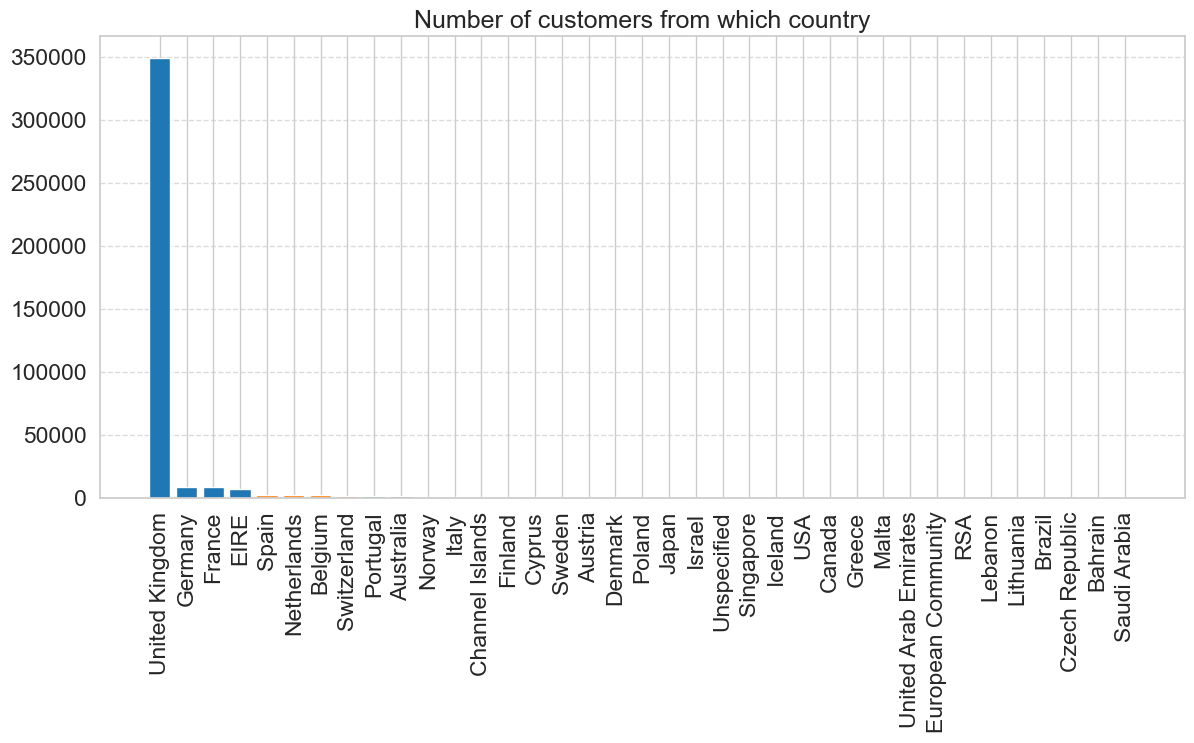

In [73]:
colors = [plt.cm.tab10(i / len(country_counts)) for i in range(len(country_counts))]

plt.figure(figsize=(14,6))
plt.bar(country_counts.index, country_counts["count"], color = colors)
plt.title('Number of customers from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

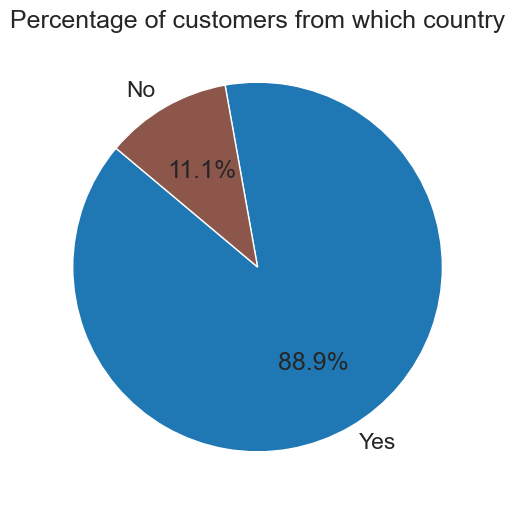

In [90]:
# percentage of Customers from UK and Rest of the World

cust_data["internal_sales"] = cust_data.apply(lambda x: "Yes" if x["Country"] == "United Kingdom" else "No", axis=1)

uk_counts = cust_data.groupby(["internal_sales"])["CustomerID"] \
                            .count() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

colors = [plt.cm.tab10(i / len(uk_counts)) for i in range(len(uk_counts))]

plt.figure(figsize=(8,6))
plt.pie(uk_counts["count"], 
    labels=uk_counts.index, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140)
plt.title('Percentage of customers from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [93]:
# by amount

country_counts = cust_data.groupby(["Country"])["amount"] \
                            .sum() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

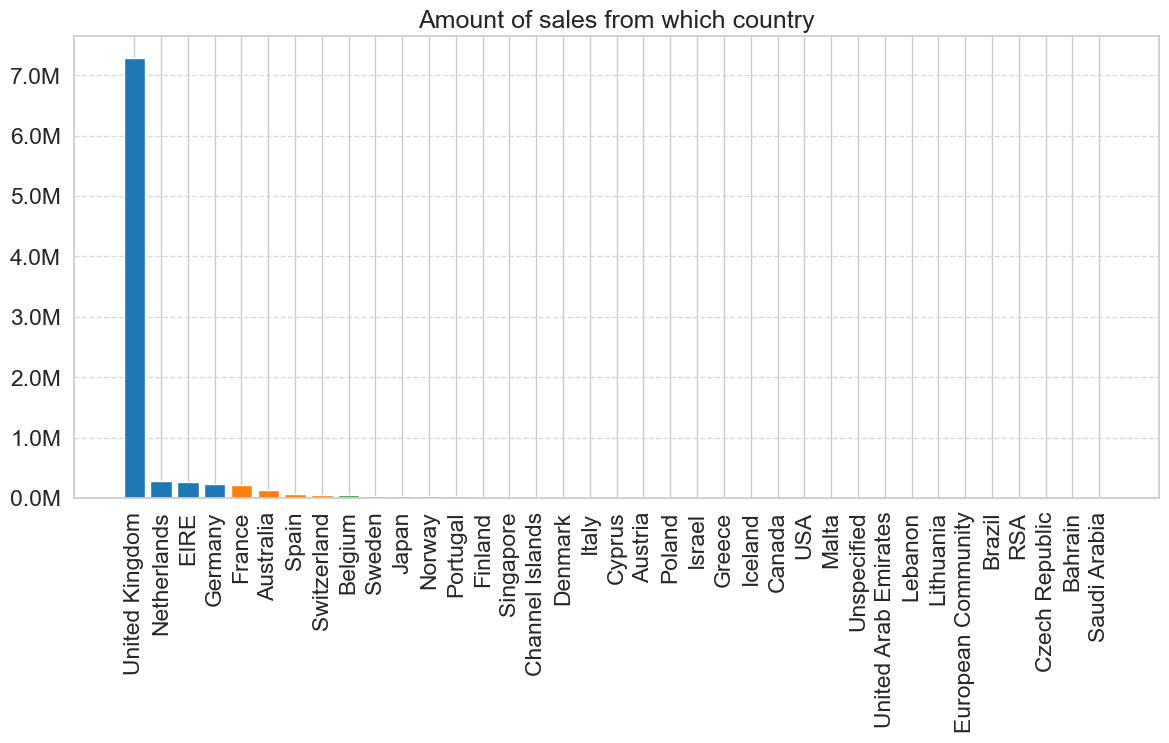

In [98]:
colors = [plt.cm.tab10(i / len(country_counts)) for i in range(len(country_counts))]

plt.figure(figsize=(14,6))
plt.bar(country_counts.index, country_counts["count"], color = colors)
plt.title('Amount of sales from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
formatter = FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

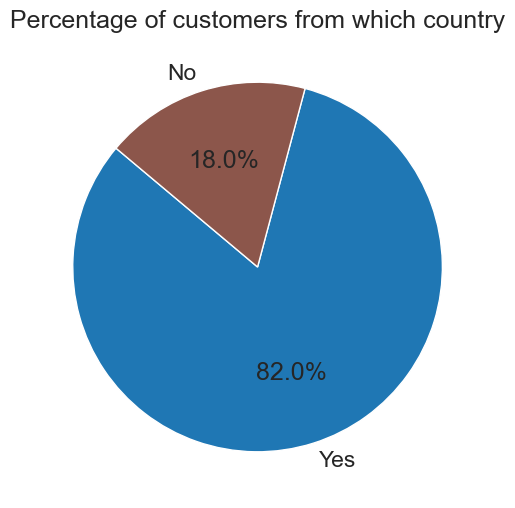

In [99]:
# percentage of sales from UK and Rest of the World
uk_counts = cust_data.groupby(["internal_sales"])["amount"] \
                            .sum() \
                            .sort_values(ascending = False) \
                            .to_frame(name = "count")

colors = [plt.cm.tab10(i / len(uk_counts)) for i in range(len(uk_counts))]

plt.figure(figsize=(8,6))
plt.pie(uk_counts["count"], 
    labels=uk_counts.index, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140)
plt.title('Percentage of customers from which country')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

In [100]:
# Top Customers

percent_sales = np.round(
    (cust_data.groupby(["CustomerID"])["amount"].sum()
     .sort_values(ascending = False)[:51]
     .sum()) / cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False).sum()*100,                                                    # Step 6: Convert the ratio to a percentage
    2)

In [113]:
# top customers

top_cust = cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False)[:51].to_frame(name = "count")

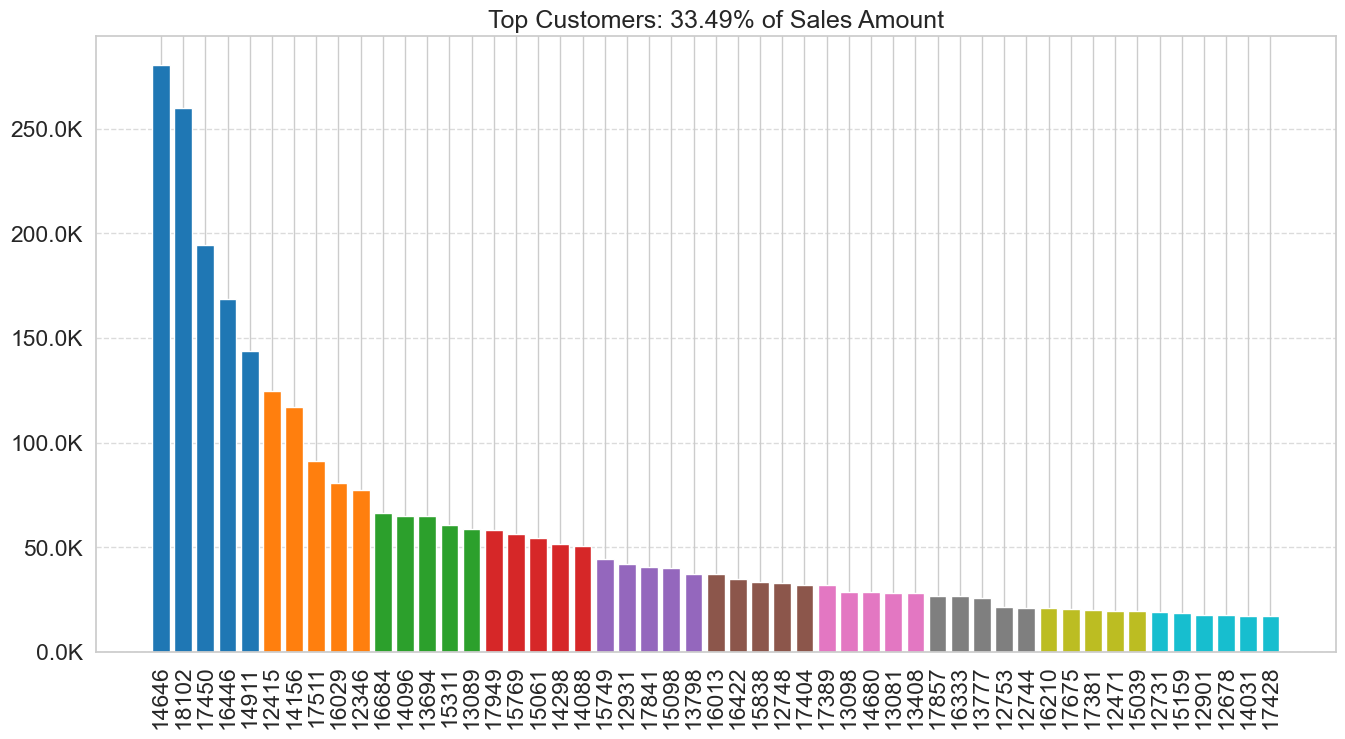

In [118]:
colors = plt.cm.tab10(np.linspace(0, 1, len(top_cust)))

plt.figure(figsize=(16, 8))
plt.bar(top_cust.index.astype(str), top_cust["count"], color = colors)
plt.title(f'Top Customers: {percent_sales}% of Sales Amount')
plt.xticks(rotation=90)

formatter = FuncFormatter(lambda x, pos: f'{x / 1000:.1f}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [121]:
# Top 15 Customers

percent_sales = np.round(
    (cust_data.groupby(["CustomerID"])["amount"].sum()
     .sort_values(ascending = False)[:15]
     .sum()) / cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False).sum()*100,                                                    # Step 6: Convert the ratio to a percentage
    2)

# top customers

top_cust = cust_data.groupby(["CustomerID"])["amount"].sum().sort_values(ascending = False)[:15].to_frame(name = "count")

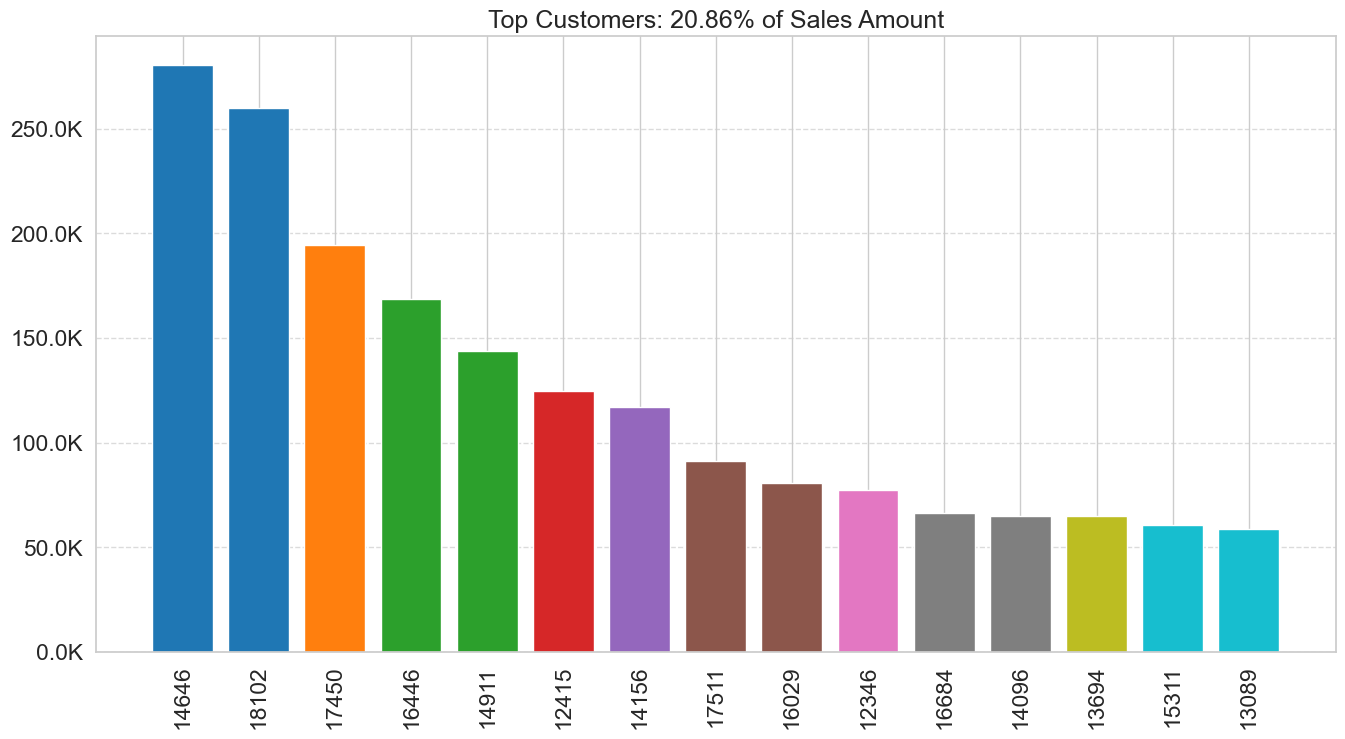

In [122]:
colors = plt.cm.tab10(np.linspace(0, 1, len(top_cust)))

plt.figure(figsize=(16, 8))
plt.bar(top_cust.index.astype(str), top_cust["count"], color = colors)
plt.title(f'Top Customers: {percent_sales}% of Sales Amount')
plt.xticks(rotation=90)

formatter = FuncFormatter(lambda x, pos: f'{x / 1000:.1f}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [134]:
# Top 15 Customers - by events

percent_sales = np.round(
    (cust_data.groupby(["CustomerID"])["amount"].count()
     .sort_values(ascending = False)[:15]
     .sum()) / cust_data.groupby(["CustomerID"])["amount"].count().sort_values(ascending = False).sum()*100,
    2)

# top customers - by events

top_cust = cust_data.groupby(["CustomerID"])["amount"].count().sort_values(ascending = False)[:15].to_frame(name = "count")

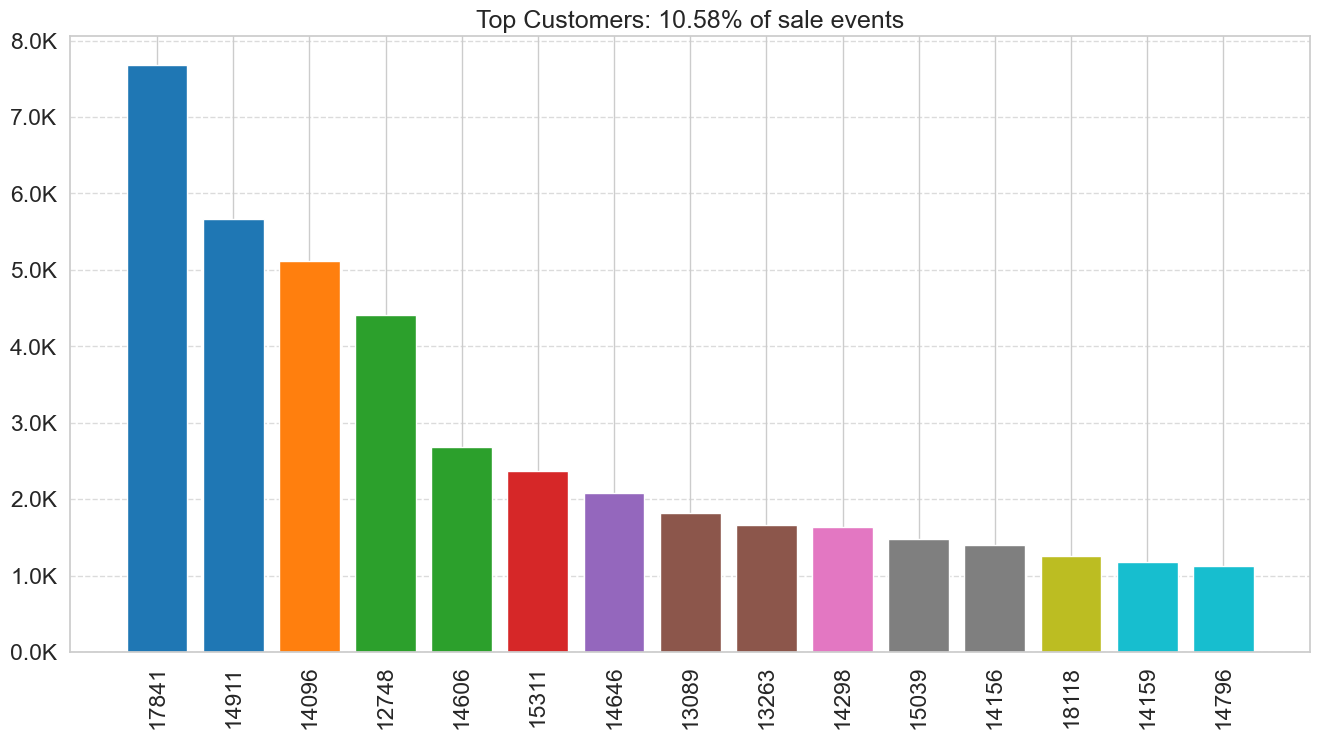

In [135]:
colors = plt.cm.tab10(np.linspace(0, 1, len(top_cust)))

plt.figure(figsize=(16, 8))
plt.bar(top_cust.index.astype(str), top_cust["count"], color = colors)
plt.title(f'Top Customers: {percent_sales}% of sale events')
plt.xticks(rotation=90)

formatter = FuncFormatter(lambda x, pos: f'{x / 1000:.1f}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [150]:
AmoutSum = cust_data.groupby(["Description"]).amount.sum().sort_values(ascending=False)
inv = cust_data.groupby("Description")["InvoiceNo"].nunique().sort_values(ascending=False)

sns.set(style="whitegrid")

In [151]:
Top15 = list(AmoutSum[:15].index)
PercentSales = np.round((AmoutSum[Top15].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15].sum() / inv.sum()) * 100, 2)

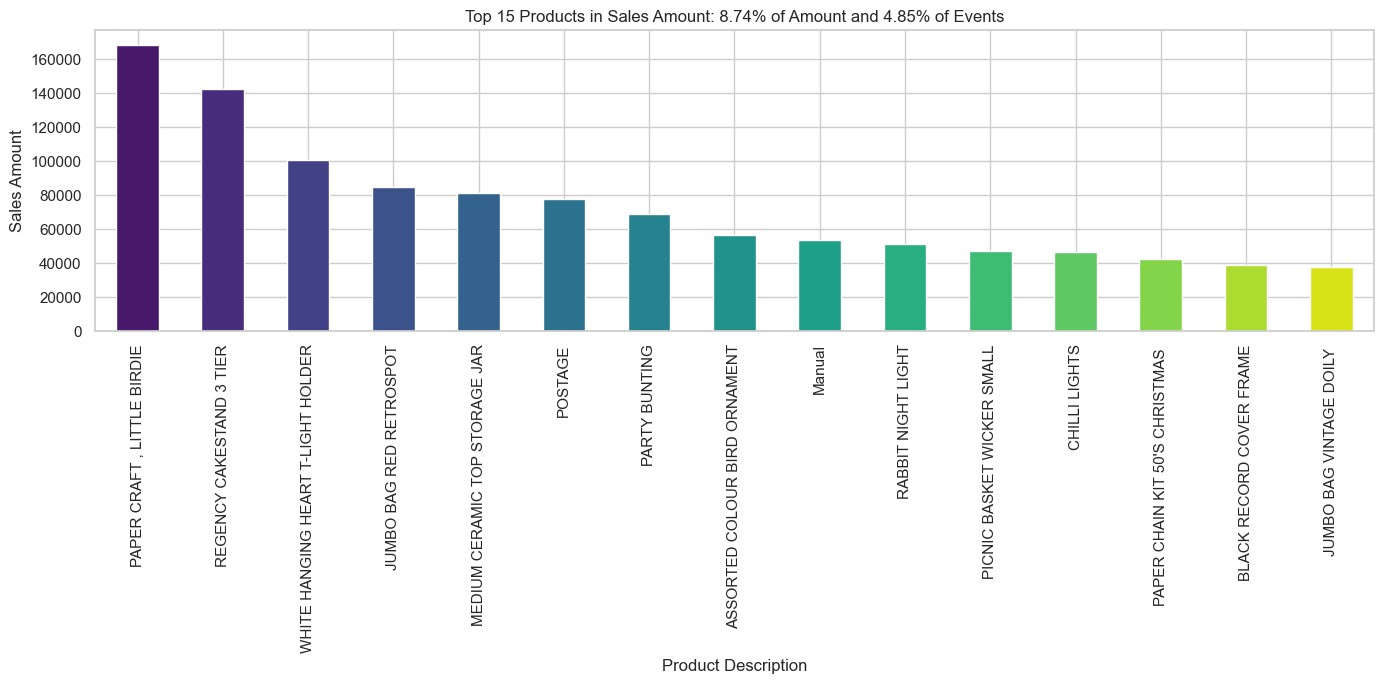

In [156]:
plt.figure(figsize=(14, 7))
colors1 = sns.color_palette("viridis", len(Top15))
AmoutSum[Top15].plot(kind='bar', color=colors1,
                     title=f'Top 15 Products in Sales Amount: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')

plt.ylabel('Sales Amount')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

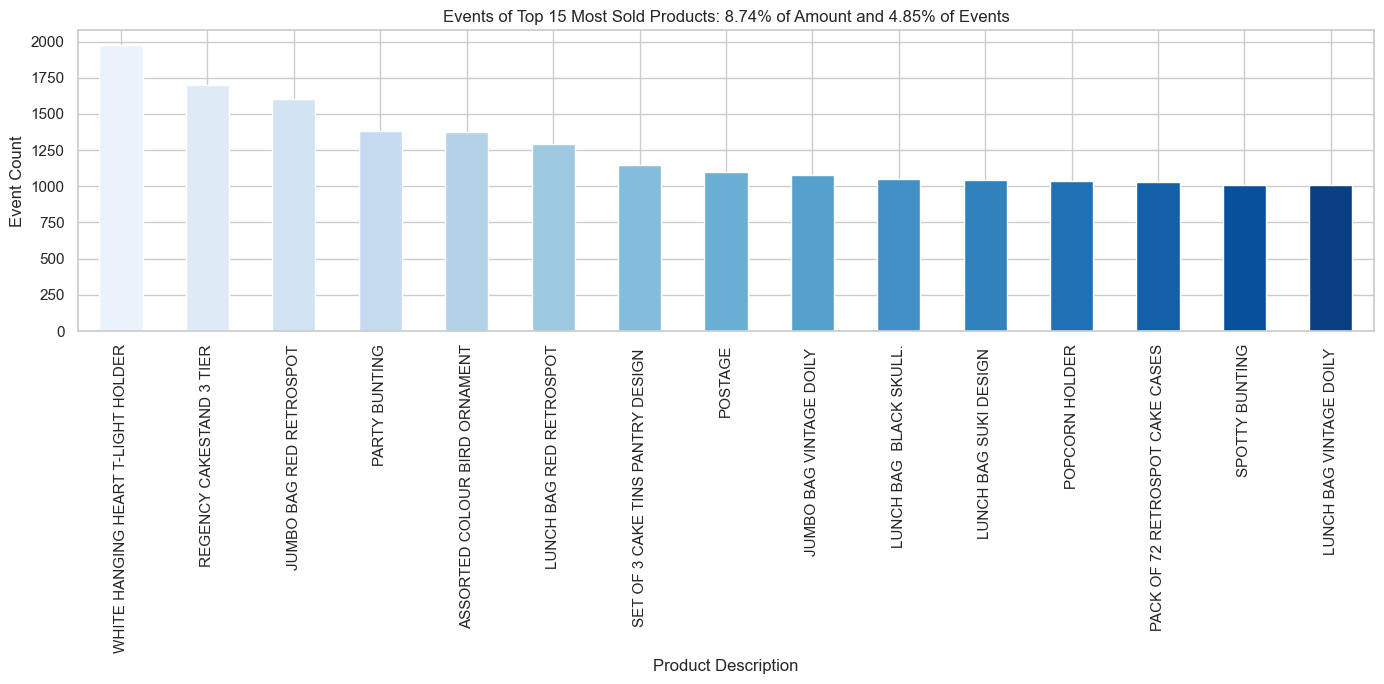

In [157]:
fig2 = plt.figure(figsize=(14, 7))
Top15Ev = list(inv[:15].index)
PercentSales = np.round((AmoutSum[Top15Ev].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15Ev].sum() / inv.sum()) * 100, 2)
colors2 = sns.color_palette("Blues", len(Top15Ev))

inv[Top15Ev].plot(kind='bar', color=colors2,
                   title=f'Events of Top 15 Most Sold Products: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Event Count')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

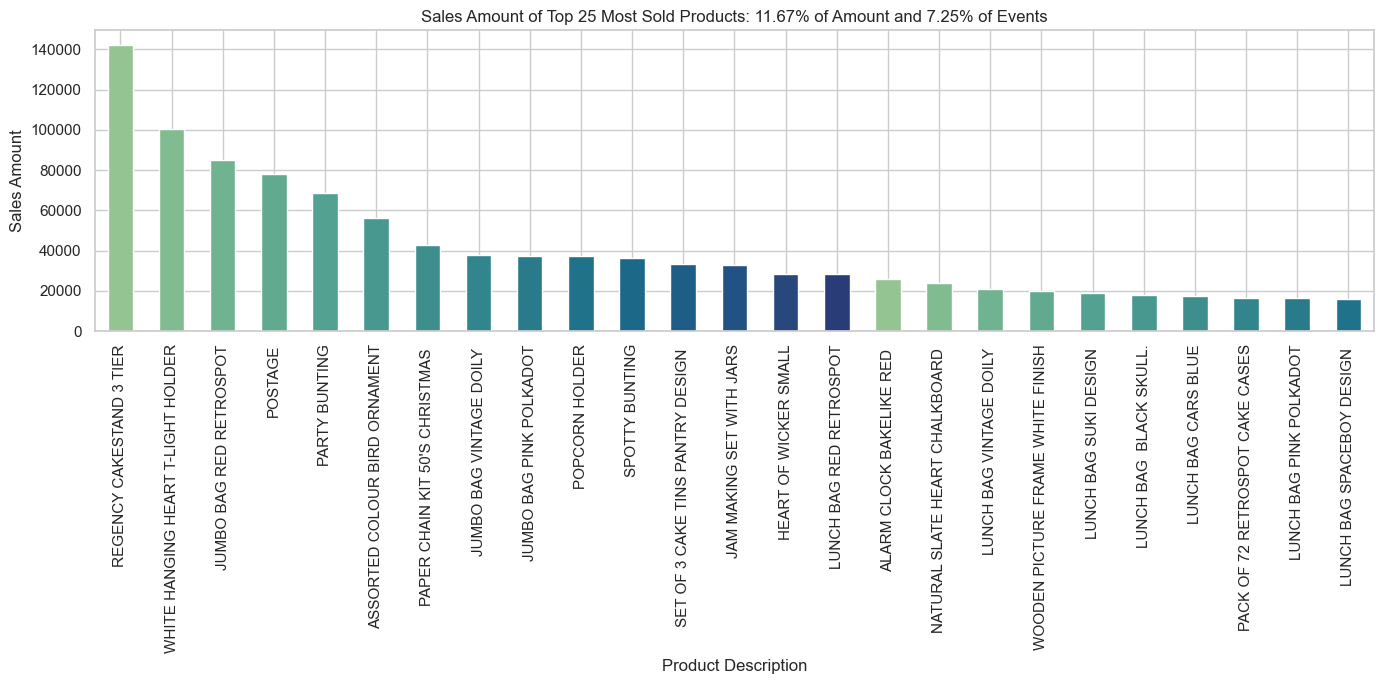

In [158]:
fig3 = plt.figure(figsize=(14, 7))
Top25ev = list(inv[:25].index)
PercentSales = np.round((AmoutSum[Top25ev].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top25ev].sum() / inv.sum()) * 100, 2)
colors3 = sns.color_palette("crest", len(Top15ev))
AmoutSum[Top25ev].sort_values(ascending=False).plot(kind='bar', color=colors3,
                                                     title=f'Sales Amount of Top 25 Most Sold Products: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Sales Amount')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

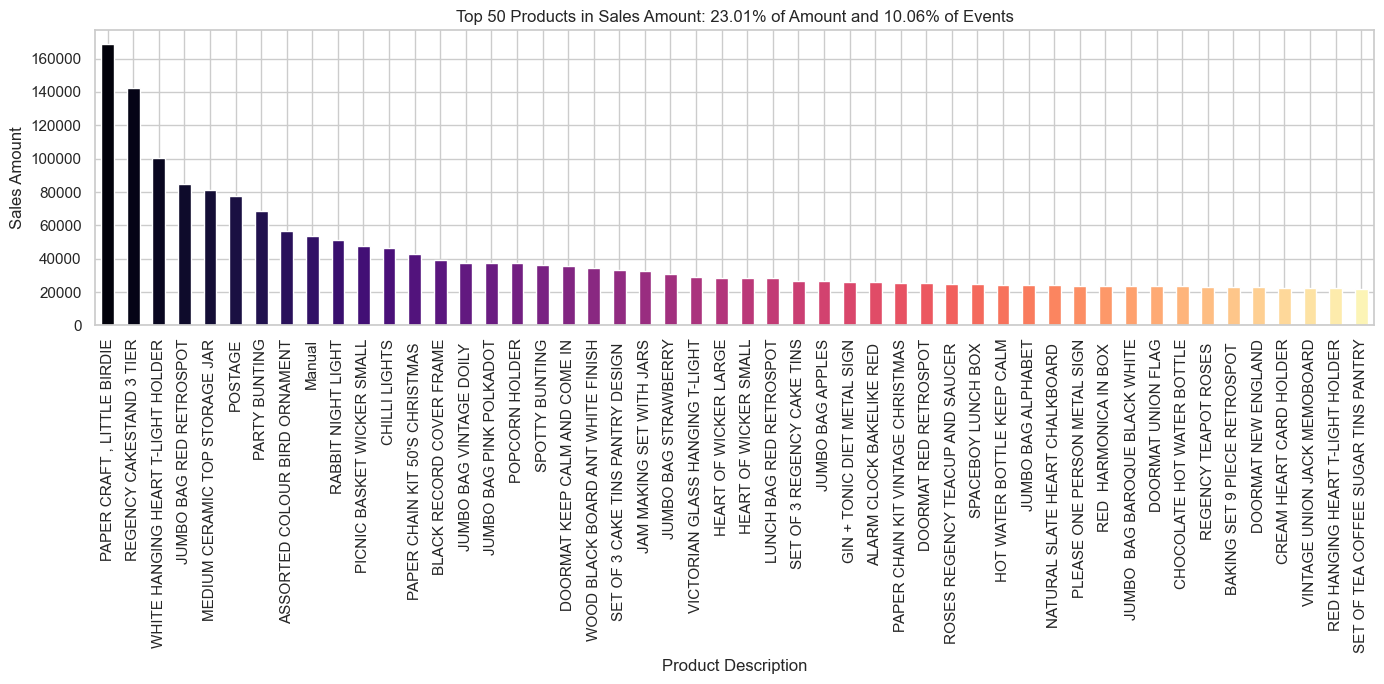

In [159]:
fig4 = plt.figure(figsize=(14, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales = np.round((AmoutSum[Top50].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum() / inv.sum()) * 100, 2)
colors4 = sns.color_palette("magma", len(Top50))
AmoutSum[Top50].plot(kind='bar', color=colors4,
                      title=f'Top 50 Products in Sales Amount: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Sales Amount')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

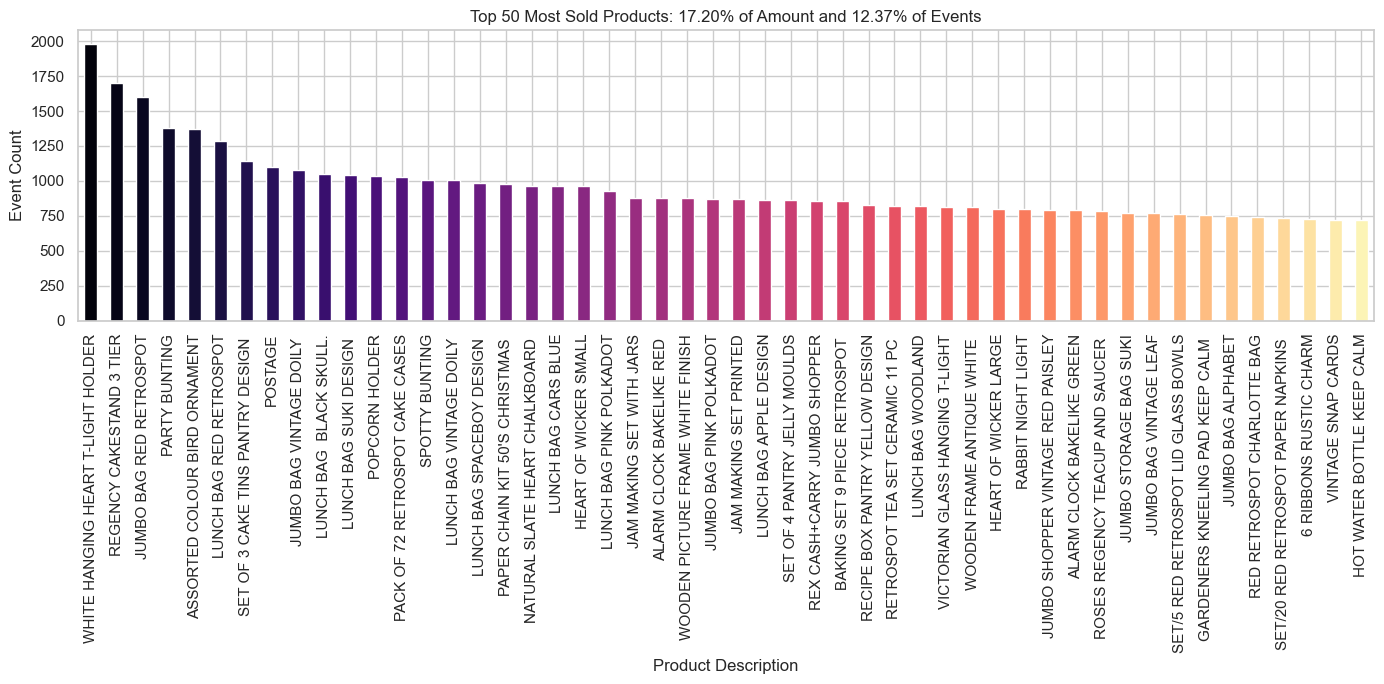

In [161]:
fig5 = plt.figure(figsize=(14, 7))
Top50Ev = list(inv[:50].index)
PercentSales = np.round((AmoutSum[Top50Ev].sum() / AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum() / inv.sum()) * 100, 2)
colors5 = sns.color_palette("magma", len(Top50Ev))
inv[Top50Ev].plot(kind='bar', color=colors5,
                  title=f'Top 50 Most Sold Products: {PercentSales:.2f}% of Amount and {PercentEvents:.2f}% of Events')
plt.ylabel('Event Count')
plt.xlabel('Product Description')
plt.tight_layout()
plt.show()

#### Customer Segmentation:

Customer segmentation involves dividing an organization’s customer base into distinct groups or segments based on various customer attributes. This process aims to identify differences in customer behaviors and patterns.

The key objectives and benefits of customer segmentation include:

1. **Higher Revenue**: This is often the primary goal of any customer segmentation initiative.
2. **Customer Understanding**: A commonly accepted business principle is “know your customer.” Segmenting the customer base allows organizations to gain deeper insights into their customers.
3. **Targeted Marketing**: Customer segmentation enables more focused and efficient marketing efforts. By understanding the distinct segments within their customer base, organizations can create tailored marketing campaigns, increasing the likelihood of their success.
4. **Optimal Product Placement**: A well-executed segmentation strategy can help firms develop new products, bundle offerings, or align product placement more effectively with customer needs.
5. **Identifying Untapped Segments**: It can also reveal latent customer segments, allowing organizations to target untapped markets through specialized marketing campaigns or business development strategies.

---

### Methods of Customer Segmentation:

**Clustering**:  
A common approach to customer segmentation is using unsupervised machine learning techniques such as clustering. This involves gathering extensive data on customer attributes, identifying clusters within the data, and analyzing the traits of these clusters to understand customer segments better.

**Exploratory Data Analysis (EDA)**:  
EDA is another method for discovering customer segments, typically performed by domain experts familiar with the products and customers. It offers a flexible approach to analyzing data, highlighting key decision points and insights.

---

### RFM Model for Customer Value:

Given a dataset limited to sales records without additional customer details, the RFM (Recency, Frequency, Monetary Value) model can be used to segment customers based on their value. This model calculates three essential attributes from customer transactions:

- **Recency**: The number of days since the customer's last purchase.
- **Frequency**: The number of transactions made by the customer.
- **Monetary Value**: The total monetary value of a customer's transactions.

To create the recency feature, a reference date is required, typically set as the day after the last transaction. The recency variable is then calculated as the number of days between the reference date and the customer’s most recent purchase date. 

By analyzing these RFM attributes, businesses can effectively segment customers and tailor strategies to maximize engagement and revenue.